In [1]:
!pip3 install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [2]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from glob import glob
import cv2
from PIL import Image
from torchvision import transforms
from torch.nn.modules import BCEWithLogitsLoss
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import time
import monai
from sklearn.model_selection import train_test_split
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
print("Is CUDA available: ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())

Is CUDA available:  False
CUDA device count:  0


In [4]:
import torchvision.models as models
from torchvision.models.resnet import ResNet34_Weights

def replace_relu_with_leakyrelu(module):
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU):
            setattr(module, name, nn.LeakyReLU(negative_slope=0.01))
        else:
            replace_relu_with_leakyrelu(child)

resnet = models.resnet34(weights=ResNet34_Weights["IMAGENET1K_V1"])
for param in resnet.parameters():
    param.requires_grad = False

replace_relu_with_leakyrelu(resnet)
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            nn.LeakyReLU(),
            resnet.layer1
        )
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return x1, x2, x3, x4

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 116MB/s]


In [5]:
class MiddleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(1,1), padding=(1,1))
        self.relu1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=(1,1), padding=(1,1))
        self.relu2 = nn.LeakyReLU()

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.bn(x)

        return x

In [6]:
# basic block untuk decoder
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(1,1), padding=(1,1))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=(1,1), padding=(1,1))
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        return x

In [7]:
class Dec_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # Up-Convolution
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # LeakyReLU
        self.relu = nn.LeakyReLU()

        # Batch normalization
        self.bn = nn.BatchNorm2d(out_channels)

        # Basic Block
        self.conv = BasicBlock(in_channels // 2 + out_channels, out_channels)

    def forward(self, inputs, skip):
        up_x = self.upconv(inputs)
        up_x = self.relu(up_x)
        up_x = self.bn(up_x)
        skip = nn.functional.interpolate(skip, size=up_x.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([up_x, skip], dim=1)
        x = self.conv(x)

        return x

In [8]:
class MergeLayer(nn.Module):
    def __init__(self):
        super(MergeLayer, self).__init__()

    def forward(self, x, skip):
        #x = nn.functional.interpolate(x, size=skip.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return x

In [9]:
class Build_Unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.encoder = Encoder()

        """ Middle Convolution """
        self.mc1 = MiddleConv(512, 1024)
        self.mc2 = MiddleConv(1024, 1024)

        """ Decoder """
        self.decoder1 = Dec_Block(1024, 512)
        self.decoder2 = Dec_Block(512, 256)
        self.decoder3 = Dec_Block(256, 128)
        self.decoder4 = Dec_Block(128, 64)

        """ Merge Layer """
        self.merge = MergeLayer()

        """ Segmentation Convolution """
        self.segmentation = nn.Conv2d(67, 1, kernel_size=1, padding=0)

    def forward(self, x):
        """ Encoder """
        x1, x2, x3, x4 = self.encoder(x)

        mc1 = self.mc1(x4)

        """ Decoder """
        d1 = self.decoder1(mc1, x4)
        d2 = self.decoder2(d1, x3)
        d3 = self.decoder3(d2, x2)
        d4 = self.decoder4(d3, x1)

        merged = self.merge(d4, x)

        out = self.segmentation(merged)

        return out

In [10]:
inputs = torch.randn((1, 3, 512, 512))
model = Build_Unet()
y = model(inputs)

print("output shape :", y.shape)

output shape : torch.Size([1, 1, 512, 512])


In [11]:
from torchvision import transforms

class ProcessDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_x = Image.open(self.x[idx])
        img_y = Image.open(self.y[idx]).convert("L")

        img_x = self.transform(img_x)
        img_y = self.transform(img_y)

        return img_x, img_y

In [12]:
""" DEVICE """
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Build_Unet()
model.to(device)

Build_Unet(
  (encoder): Encoder(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): LeakyReLU(negative_slope=0.01)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [13]:
from google.colab import drive
drive.mount('/content/drive')
# path = r'C:\Vira\Training Data'
# image_path = os.path.join(path, 'DATA ALL 1')
# mask_path = os.path.join(path, 'MASK ALL')


Mounted at /content/drive


In [14]:
class ProcessDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        image_name = os.path.basename(self.image_paths[idx])
        return image, mask, image_name

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor()
])

In [15]:
""" HYPERPARAMETERS """
BATCHSIZE = 1
EPOCHS = 1

""" DATASETS """
train_x = sorted(glob("/content/drive/My Drive/DATA ALL 1/*"))
train_y = sorted(glob("/content/drive/My Drive/MASK ALL/*"))
dataset = ProcessDataset(train_x, train_y, transform=transform)

""" DATASETS """
tes_x = sorted(glob("/content/drive/My Drive/DATA ALL 1/*"))
tes_y = sorted(glob("/content/drive/My Drive/MASK ALL/*"))
dataset2 = ProcessDataset(tes_x, tes_y, transform=transform)


# Define the transformation
transform = transforms.Compose([
    transforms.Resize((360, 450)),  # Resize images and masks to 256x256
    transforms.ToTensor()
])


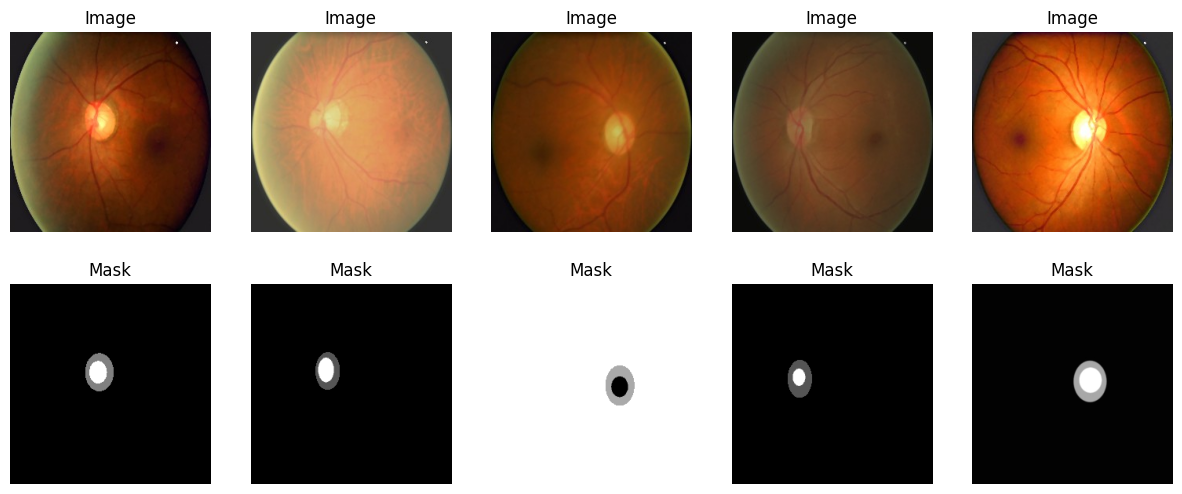

Dimensi gambar: torch.Size([3, 256, 256])


In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Ambil beberapa contoh gambar dari dataset
num_samples = 5
sample_indices = [0, 10, 20, 30, 40]  # Contoh indeks dari dataset

# Plot contoh gambar
plt.figure(figsize=(15, 6))
for i, idx in enumerate(sample_indices):
    # Ambil gambar dan mask dari dataset
    image, mask, filename = dataset2[idx]

    # Konversi tensor PyTorch ke array NumPy dan ubah saluran warna
    image = TF.to_pil_image(image)
    mask = TF.to_pil_image(mask)

    # Plot gambar dan mask
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

plt.show()

# Ambil contoh pertama dari dataset
sample_image, sample_mask, sample_filename = dataset2[0]

# Cetak dimensi gambar
print("Dimensi gambar:", sample_image.shape)


In [17]:
# import matplotlib.pyplot as plt

# # Fungsi untuk menampilkan beberapa gambar dan mask
# def visualize_images_with_masks(images, masks, num_samples=5):
#     plt.figure(figsize=(15, 5*num_samples))
#     for i in range(num_samples):
#         plt.subplot(num_samples, 2, i*2 + 1)
#         plt.imshow(images[i])
#         plt.title('Image')
#         plt.axis('off')

#         plt.subplot(num_samples, 2, i*2 + 2)
#         plt.imshow(masks[i], cmap='gray')
#         plt.title('Mask')
#         plt.axis('off')
#     plt.show()

# Mencetak jumlah gambar dan mask yang berhasil dimuat
print("Jumlah gambar yang berhasil dimuat:", len(dataset))
print("Jumlah mask yang berhasil dimuat:", len(dataset2))

# # Menampilkan beberapa gambar dan mask
# visualize_images_with_masks(dataset, dataset2)


Jumlah gambar yang berhasil dimuat: 1001
Jumlah mask yang berhasil dimuat: 1001


In [18]:
# # Fungsi untuk menginisialisasi model U-Net
# def initialize_unet():
#     model = Build_Unet()  # Anda mungkin perlu menyesuaikan ini sesuai dengan implementasi Anda
#     model.to(device)
#     return model

# # Inisialisasi model
# model = initialize_unet()

# # Definisikan optimizer dan loss function
# optimizer = optim.Adam(model.parameters())
# criterion = nn.CrossEntropyLoss()

# # Data loader untuk training
# train_loader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True)

# # Loop melalui epoch
# for epoch in range(EPOCHS):
#     model.train()  # Pastikan model dalam mode pelatihan
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         # Reset gradients
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs)

#         # Hitung loss
#         loss = criterion(outputs, labels)

#         # Backward pass dan optimasi
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     # Cetak statistik pelatihan setiap epoch
#     print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader)}")

# print("Training selesai.")

In [19]:
BATCHSIZE

1

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm

# Definisikan fungsi untuk menginisialisasi model U-Net
def initialize_unet():
    model = Build_Unet()
    model.to(device)
    return model

# Definisikan fungsi untuk memuat model
def load_model(model_path):
    # Inisialisasi model dengan arsitektur yang sesuai
    model = Build_Unet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    # Setel model ke mode evaluasi
    model.eval()
    return model

# Definisikan fungsi untuk visualisasi segmentasi
def visualize_segmentation(model, test_loader, num_samples=1000):
    model.eval()  # Pastikan model dalam mode evaluasi
    total_pixels = 0
    correct_pixels = 0
    cdr_values = []

    # Buat direktori untuk menyimpan gambar hasil segmentasi
    save_dir = "segmentation_results_99"
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for i, (inputs, labels, file_names) in enumerate(tqdm(test_loader, total=num_samples, desc="Processing")):
            if i >= num_samples:
                break

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Ambil kelas dengan probabilitas tertinggi sebagai prediksi
            _, predicted_masks = torch.max(outputs, dim=1)

            # Calculate pixel-wise accuracy
            correct_pixels += (predicted_masks == labels).sum().item()
            total_pixels += labels.numel()

            # Konversi tensor PyTorch menjadi array NumPy untuk visualisasi
            input_image = inputs[0].permute(1, 2, 0).cpu().numpy()
            true_mask = labels[0].squeeze().cpu().numpy()  # Menghapus dimensi batch
            predicted_mask = predicted_masks[0].squeeze().cpu().numpy()  # Menghapus dimensi batch

            # Hitung CDR
            CDR = calculate_cdr(true_mask)  # Anda perlu mengimplementasikan fungsi ini

            # Store the CDR value with the corresponding index
            cdr_values.append({'File Name': file_names[0], 'CDR': CDR})

            # Extract the base name of the file (without extension)
            base_name = os.path.splitext(os.path.basename(file_names[0]))[0]

            # Simpan input image, true mask, dan predicted mask sebagai file gambar
            input_image_path = os.path.join(save_dir, f"{base_name}_input_image.png")
            true_mask_path = os.path.join(save_dir, f"{base_name}_true_mask.png")
            predicted_mask_path = os.path.join(save_dir, f"{base_name}_predicted_mask.png")
            overlay_image_path = os.path.join(save_dir, f"{base_name}_overlay.png")

            # Simpan input image
            input_img = Image.fromarray((input_image * 255).astype(np.uint8))
            input_img.save(input_image_path)

            # Simpan true mask
            true_mask_img = Image.fromarray((true_mask * 255).astype(np.uint8))
            true_mask_img.save(true_mask_path)

            # Simpan predicted mask
            predicted_mask_img = Image.fromarray((predicted_mask * 255).astype(np.uint8))
            predicted_mask_img.save(predicted_mask_path)

            # Simpan overlay image
            fig, ax = plt.subplots()
            ax.imshow(input_image, cmap='gray')
            ax.imshow(true_mask, alpha=0.5, cmap='jet')
            ax.axis('off')
            fig.savefig(overlay_image_path, bbox_inches='tight', pad_inches=0)
            plt.close(fig)

    # Simpan nilai CDR ke CSV
    df = pd.DataFrame(cdr_values)
    df.to_csv('cdr_values_new_99.csv', index=False)
    print("CDR values saved to cdr_values_new_99.csv")

def area_of_cup(segmentation_mask):
    cup_area = (segmentation_mask > 0).sum()
    return cup_area

def area_of_disc(segmentation_mask):
    disc_area = (segmentation_mask == 0).sum()
    return disc_area

def calculate_cdr(segmentation_mask):
    cup_area = area_of_cup(segmentation_mask)
    disc_area = area_of_disc(segmentation_mask)
    cdr = cup_area / (cup_area + disc_area)
    return cdr

# Memuat dataset dan model Anda
test_loader = DataLoader(dataset2, batch_size=BATCHSIZE, shuffle=False)

# Tentukan path file tempat model Anda disimpan
model_path = 'Training 5.pth'

# Memuat model dari file
loaded_model = load_model(model_path)

# Visualisasikan hasil segmentasi dengan model yang dimuat
visualize_segmentation(loaded_model, test_loader)

Processing: 100%|██████████| 1000/1000 [46:22<00:00,  2.78s/it]

CDR values saved to cdr_values_new_99.csv


In [24]:
import os
import zipfile

def zip_results(save_dir, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        # Tambahkan semua file dalam direktori save_dir ke ZIP file
        for root, _, files in os.walk(save_dir):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, save_dir))
    print(f"All results saved to {zip_filename}")

# Tentukan direktori hasil segmentasi dan nama file ZIP
save_dir = "segmentation_results_99"
zip_filename = "segmentation_results_99.zip"

# Zip hasil segmentasi
zip_results(save_dir, zip_filename)


All results saved to segmentation_results_99.zip


In [ ]:
# Save the model
model_save_path = 'Training 2.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [ ]:
# from sklearn.model_selection import KFold
# from torch.utils.data.dataset import Subset

# # split dataset menjadi 10 subset
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# dice_scores = []  # Untuk menyimpan skor Dice coefficient dari setiap fold

# # Inisialisasi dictionary untuk menyimpan training history
# H = {}
# for fold in range(10):
#     H[f"train_loss_{fold}"] = []
#     H[f"test_loss_{fold}"] = []
#     H[f"dice_train_{fold}"] = []
#     H[f"dice_val_{fold}"] = []

# startTime = time.time()
# # loop melalui setiap fold
# for fold, (train_index, test_index) in enumerate(kf.split(dataset)):
#     print(f"Fold {fold + 1}/{kf.get_n_splits()}")
#     train_dataset = Subset(dataset, train_index)
#     val_dataset = Subset(dataset, test_index)

#     # inisialisasi loader pelatihan dan pengujian
#     train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

#     # Mendapatkan jumlah data train dan validasi
#     num_train_data = len(train_dataset)
#     num_val_data = len(val_dataset)

#     # Menampilkan jumlah data train dan validasi
#     print("Jumlah data train:", num_train_data)
#     print("Jumlah data validasi:", num_val_data)

#     # hitung steps per epoch untuk training dan test set
#     trainSteps = len(train_dataset) // BATCHSIZE
#     valSteps = len(val_dataset) // BATCHSIZE

#     LR = 1e-3
#     criterion = BCEWithLogitsLoss()
#     criterion.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=LR)

#     for epoch in range(EPOCHS):
#         totalTrainLoss = 0
#         total_dice_train = 0
#         dice_metric_train = DiceMetric(include_background=False, reduction="mean")
#         all_train_preds = []
#         all_train_targets = []

#         # training mode
#         model.train()

#         for i, (data, target) in enumerate(train_loader):
#             # pindahkan data ke perangkat yang sesuai
#             data, target = data.to(device), target.to(device)

#             # kirim data ke dalam model
#             output = model(data)

#             # hitung loss
#             loss = criterion(output, target)

#             # convert output to binary predictions
#             pred = torch.round(torch.sigmoid(output))

#             # backpropagation dan update parameter
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             totalTrainLoss += loss.item()

#             # tambahkan prediksi dan label target ke variabel total
#             all_train_preds.append(pred)
#             all_train_targets.append(target)

#         # gabungkan prediksi dan label target menjadi tensor yang sesuai
#         all_train_preds = torch.cat(all_train_preds, dim=0)
#         all_train_targets = torch.cat(all_train_targets, dim=0)

#         # hitung DSC menggunakan tensor prediksi dan label target secara keseluruhan
#         dice_score_train = dice_metric_train(all_train_preds, all_train_targets)
#         avg_dice_train = dice_score_train.mean().item()

#         with torch.no_grad():
#             totalTestLoss = 0
#             total_dice_val = 0
#             dice_metric_val = DiceMetric(include_background=False, reduction="mean")
#             all_preds = []
#             all_targets = []

#             # validasi mode
#             model.eval()

#             for i, (data, target) in enumerate(val_loader):
#                 # pindahkan data ke perangkat yang sesuai
#                 data, target = data.to(device), target.to(device)

#                 # kirim data ke dalam model
#                 output = model(data)

#                 # convert output to binary predictions
#                 pred = torch.round(torch.sigmoid(output))

#                 # hitung loss
#                 loss = criterion(output, target)
#                 totalTestLoss += loss.item()

#                 # tambahkan prediksi dan label target ke variabel total
#                 all_preds.append(pred)
#                 all_targets.append(target)

#         # gabungkan prediksi dan label target menjadi tensor yang sesuai
#         all_preds = torch.cat(all_preds, dim=0)
#         all_targets = torch.cat(all_targets, dim=0)

#         # hitung DSC menggunakan tensor prediksi dan label target secara keseluruhan
#         dice_score_val = dice_metric_val(all_preds, all_targets)
#         avg_dice_val = dice_score_val.mean().item()

#         # hitung rata-rata training dan test loss
#         avgTrainLoss = totalTrainLoss / trainSteps
#         avgTestLoss = totalTestLoss / valSteps

#         # Hitung rata-rata Dice coefficient untuk fold saat ini
#         average_dice_score_fold = np.mean(H[f"dice_val_{fold}"])
#         dice_scores.append(average_dice_score_fold)

# 	      # update training history
#         H[f"train_loss_{fold}"].append(avgTrainLoss)
#         H[f"test_loss_{fold}"].append(avgTestLoss)
#         H[f"dice_train_{fold}"].append(avg_dice_train)
#         H[f"dice_val_{fold}"].append(avg_dice_val)

#         # print informasi training
#         print("EPOCH: {}/{}".format(epoch + 1, EPOCHS))
#         print("Train loss: {:.4f} | Val loss: {:.4f}".format(
# 	        avgTrainLoss, avgTestLoss))
#         print("DSC Train : {:.4f} | DSC Val : {:.4f}".format(avg_dice_train, avg_dice_val))

#     # display total waktu training
#     endTime = time.time()
#     print("[INFO] total time taken to train the model: {:.2f}s".format(
# 	    endTime - startTime))
# torch.save(model.state_dict(), 'tesma10fold.pth')

# # Hitung rata-rata Dice coefficient dari seluruh fold dalam cross-validation
# average_dice_score_cv = np.mean(dice_scores)
# print(f"Cross-Validation Dice coefficient: {average_dice_score_cv:.2f}")

In [ ]:
# def build_unet(input_shape):
#     inputs = Input(input_shape)

#     # Contracting Path
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     # Bottleneck
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

#     # Expansive Path
#     up5 = UpSampling2D(size=(2, 2))(conv4)
#     up5 = Conv2D(256, 2, activation='relu', padding='same')(up5)
#     merge5 = concatenate([conv3, up5], axis=3)
#     conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
#     conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

#     up6 = UpSampling2D(size=(2, 2))(conv5)
#     up6 = Conv2D(128, 2, activation='relu', padding='same')(up6)
#     merge6 = concatenate([conv2, up6], axis=3)
#     conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

#     up7 = UpSampling2D(size=(2, 2))(conv6)
#     up7 = Conv2D(64, 2, activation='relu', padding='same')(up7)
#     merge7 = concatenate([conv1, up7], axis=3)
#     conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

#     # Output layer
#     output = Conv2D(1, 1, activation='sigmoid')(conv7)

#     model = Model(inputs=inputs, outputs=output)
#     return model

In [ ]:
# def load_subset_data(dataset_dir, subset_size=100):
#     images = []
#     masks = []
#     count = 0
#     for filename in os.listdir(dataset_dir):
#         if count >= subset_size:
#             break
#         if filename.endswith(".jpg"):
#             image_path = os.path.join(dataset_dir, filename)
#             mask_path = os.path.join(dataset_dir, filename.split('.')[0] + '.png')  # Assuming mask file format is .png
#             image = cv2.imread(image_path)
#             mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
#             if mask is not None:  # Pastikan mask tidak None
#                 images.append(image)
#                 masks.append(mask)
#                 count += 1
#     return np.array(images), np.array(masks)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# # # Persiapan data
# train_images_subset, train_masks_subset = load_subset_data('/content/drive/My Drive/test', subset_size=50)
# # train_images, train_masks = load_data('/content/drive/My Drive/test')  # Ganti 'train/' dengan path ke folder train Anda
# input_shape = train_images_subset.shape[1:]

# # Path ke direktori yang berisi gambar dan mask
# # data_dir = '/content/drive/My Drive/test/'

# # # Mendapatkan daftar file gambar dan mask
# # # Mendapatkan daftar file gambar dan mask (batasi hanya 50)
# # image_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.jpg')][:20]
# # mask_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.png')][:20]


# # # # Dimensi input gambar
# # input_shape = (512, 512, 3)

In [ ]:
# # Bangun dan kompilasi model U-Net
# model = build_unet(input_shape)
# model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=[Accuracy()])

# # Callback untuk TensorBoard
# tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# # Melatih model menggunakan generator
# batch_size = 8
# num_samples = len(image_files)
# steps_per_epoch = num_samples // batch_size
# model.fit(data_generator(image_files, mask_files, batch_size),
#           steps_per_epoch=steps_per_epoch,
#           epochs=4,
#           callbacks=[tensorboard_callback])

In [ ]:
# import time

# # Prediksi beberapa gambar menggunakan model
# num_images_to_predict = 5  # Tentukan jumlah gambar yang ingin diprediksi

# start_time = time.time()  # Catat waktu awal prediksi

# predicted_masks = model.predict(data_generator(image_files[:num_images_to_predict], mask_files[:num_images_to_predict], batch_size))

# end_time = time.time()  # Catat waktu akhir prediksi
# total_time = end_time - start_time  # Hitung total waktu prediksi
# print("Total time for prediction:", total_time, "seconds")

# # Menampilkan gambar-gambar hasil prediksi
# import matplotlib.pyplot as plt

# for i in range(num_images_to_predict):
#     plt.figure(figsize=(12, 6))

#     # Gambar asli
#     plt.subplot(1, 3, 1)
#     original_image = cv2.imread(image_files[i])
#     plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
#     plt.title("Original Image")
#     plt.axis("off")

#     # Mask yang seharusnya
#     plt.subplot(1, 3, 2)
#     true_mask = cv2.imread(mask_files[i], cv2.IMREAD_GRAYSCALE)
#     plt.imshow(true_mask, cmap='gray')
#     plt.title("True Mask")
#     plt.axis("off")

#     # Mask hasil prediksi
#     plt.subplot(1, 3, 3)
#     predicted_mask = predicted_masks[i].squeeze()  # Hapus dimensi yang tidak diperlukan
#     plt.imshow(predicted_mask, cmap='gray')
#     plt.title("Predicted Mask")
#     plt.axis("off")

#     plt.show()


In [ ]:
# from tensorflow.keras.callbacks import TensorBoard

# # Callback untuk TensorBoard
# tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# # Bangun dan kompilasi model U-Net
# model = build_unet(input_shape)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Melatih model
# history = model.fit(train_images_subset, train_masks_subset, batch_size=4, epochs=4, validation_split=0.2, callbacks=[tensorboard_callback])

# # Menampilkan proses pelatihan
# plt.figure(figsize=(12, 6))

# # Loss
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# # Accuracy
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # Fungsi untuk menampilkan gambar asli, mask, dan hasil segmentasi
# def visualize_segmentation(images, masks, predictions):
#     num_samples = images.shape[0]
#     plt.figure(figsize=(15, 5*num_samples))
#     for i in range(num_samples):
#         plt.subplot(num_samples, 3, i*3 + 1)
#         plt.imshow(images[i])
#         plt.title('Original Image')
#         plt.axis('off')

#         plt.subplot(num_samples, 3, i*3 + 2)
#         plt.imshow(masks[i], cmap='gray')
#         plt.title('Ground Truth Mask')
#         plt.axis('off')

#         plt.subplot(num_samples, 3, i*3 + 3)
#         brightened_prediction = np.clip(predictions[i] * 5, 0, 1)  # Tingkatkan kecerahan hasil prediksi
#         plt.imshow(brightened_prediction, cmap='gray')
#         plt.title('Predicted Mask')
#         plt.axis('off')
#     plt.show()

# # Membuat prediksi menggunakan model
# predictions = model.predict(train_images_subset)

# # Menampilkan hasil segmentasi untuk beberapa sampel
# visualize_segmentation(train_images_subset[:5], train_masks_subset[:5], predictions[:5])
